In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure3'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)].iloc[:5]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
reload(sdos)
import get_all_switch_add_metrics as gasam
reload(gasam)

import preprocess_one_session as prepos

In [4]:
%%time
all_fields_recombined_all = {}
pf_params_recombined_all = {}
fr_map_trial_df_all = {}
pval_all = {}
best_n_all = {}
X_pwc_all = {}
X_raw_all = {}
changes_df_all = {}
var_res_all = {}
corr_all = {}
all_sw_d_all = {}
all_sw_with_metrics_d_all = {}
trial_index_to_index_within_df_all = {}

spk_beh_df_all = {}
cell_cols_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    res=dpp.load_spk_beh_df(data_dir_full,load_only=True)
    if res is not None:
        spk_beh_df = res['spk_beh_df']
        spk_beh_df,_ = dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
        spk_beh_df_all[ani,sess] = spk_beh_df
        trial_index_to_index_within_df = dpp.trial_index_to_index_within_trialtype(spk_beh_df)
        trial_index_to_index_within_df_all[ani,sess] = trial_index_to_index_within_df
        cell_cols_d =res['cell_cols_d']
        cell_cols_d_all[ani,sess]=cell_cols_d

    pf_res_recombine = pfrc.main(data_dir_full,force_reload=False,load_only=True)

    all_fields_recombined=pf_res_recombine['all_fields_recombined']
    all_fields_recombined_all[ani,sess] = all_fields_recombined
    pf_params_recombined = pf_res_recombine['params_recombined']
    pf_params_recombined_all[ani,sess] = pf_params_recombined

    fr_map_all = fmos.main(data_dir_full,force_reload=False,load_only=True)
    fr_map_trial_df = fr_map_all['fr_map_trial_df']
    fr_map_trial_df_all[ani,sess] = fr_map_trial_df



    sw_res = sdos.main(data_dir_full,force_reload=False,load_only=True)
    pval = sw_res['pval']
    pval_all[ani,sess]=pval
    best_n = sw_res['best_n']
    best_n_all[ani,sess] = best_n
    X_pwc = sw_res['X_pwc']
    X_pwc_all[ani,sess] = X_pwc
    X_raw = sw_res['X_raw']
    X_raw_all[ani,sess]=X_raw
    changes_df = sw_res['changes_df']
    changes_df_all[ani,sess] = changes_df
    var_res = sw_res['var_res']
    var_res_all[ani,sess]=var_res
    corr = sw_res['corr']
    corr_all[ani,sess] = corr

    sw_info_res=gasam.main(data_dir_full,force_reload=False,load_only=True)
    if sw_info_res is None:
        sw_info_res=gasam.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res['all_sw_d']
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res['all_sw_with_metrics_d']
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d

all_fields_recombined_all = pd.concat(all_fields_recombined_all,axis=0)
pf_params_recombined_all = pd.concat(pf_params_recombined_all,axis=0)
fr_map_trial_df_all = pd.concat(fr_map_trial_df_all,axis=0)
pval_all = pd.concat(pval_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
all_sw_d_all = pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)
best_n_all = pd.concat(best_n_all,axis=0)

spk_beh_df_all = pd.concat(spk_beh_df_all,axis=0)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan_recombine.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_res_afterheadscan_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_fr_mean.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_d

In [5]:
import pairwise_analysis as pwa
reload(pwa)
import switch_metrics as sm
reload(sm)
import test_co_switch as tcs
reload(tcs)
import shuffle_changes_df_one_session as scdos

In [25]:
row = subdb.iloc[0]
task_index=0
data_dir_full=ddf = row['data_dir_full']
ani=row['animal_name.1']
sess = row['sess_name']
# ani,sess,task_index = 'e13_26m1','e13_26m1_210913',0
changes_df_one = changes_df_all.loc[ani,sess,task_index]
all_sw_d_one = all_sw_d_all.loc[ani,sess,task_index]
pf_params_recombined_one=pf_params_recombined_all.loc[ani,sess]
# changes_df_one = changes_df_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[ani,sess]
cell_cols_d = cell_cols_d_all[ani,sess]
fr_map_trial_df = fr_map_trial_df_all.loc[ani,sess,task_index]
trial_index_to_index_within_df_one = trial_index_to_index_within_df_all[ani,sess]

In [36]:
sw_sim_allonoff,time_diff = pwa.get_sw_sim(all_sw_d_one,diff_key='trial_index',win_l=[0,1,2],decay_rate_l=[])



In [26]:
# generic preoprocess
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']
cell_metrics=mat_to_return['cell_metrics']
mergepoints = mat_to_return['mergepoints']

res_all_epochs_d, ripple_time_ints_epochs_d = prep.get_spike_count_rate_participation_in_ripple_all(cell_metrics,
                                                                                                    ripples,
                                                                                                    mergepoints,
                                                                                                   )

import pairwise_analysis as pwa
reload(pwa)
ripple_sim_d = pwa.get_all_ripple_pairwise_sim(cell_metrics,ripples,mergepoints)

In [27]:
ep = 0
ripple_key = 'participation_in_interval'
# ripple_firing_mat_one_ep = res_all_epochs_d['ripple_only']['count_in_interval'][ep]
ripple_firing_mat_one_ep = res_all_epochs_d['ripple_only'][ripple_key][ep]
ripple_firing_mat_one_ep = ripple_firing_mat_one_ep.loc[cell_cols_d['pyr']]

<Axes: xlabel='None-None'>

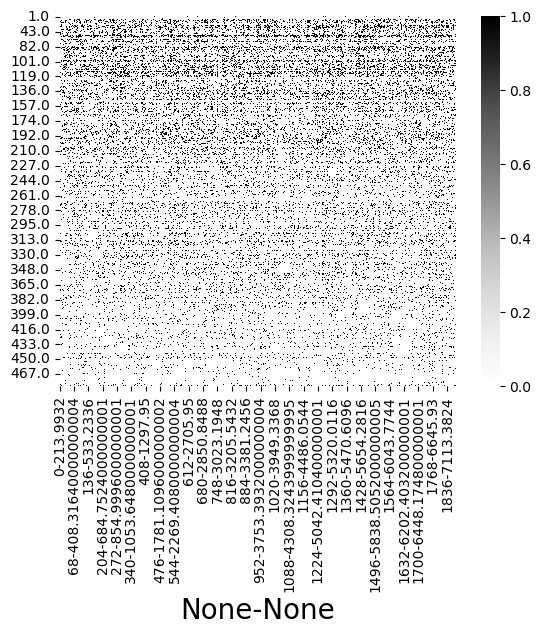

In [28]:
sns.heatmap(data=ripple_firing_mat_one_ep,cmap='Greys')

In [10]:
from scipy.spatial.distance import pdist,squareform

In [42]:
onoff = 1
sw_sim_one = sw_sim_allonoff.loc[onoff,'within_0'].dropna(axis=1,how='all')

In [30]:
ep = 2
ripple_sim_one = ripple_sim_d.loc['ripple_only',ripple_key,ep].loc[cell_cols_d['pyr'],cell_cols_d['pyr']]

/tmp/ipykernel_878037/502702861.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  ripple_sim_one = ripple_sim_d.loc['ripple_only',ripple_key,ep].loc[cell_cols_d['pyr'],cell_cols_d['pyr']]


In [21]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

In [32]:
def prep_switch_trial_for_trialtype_seperated_heatmap(row,trial_index_to_index_within_df_one,trialtype_for_heatmap,task_index=0):
    index_within =row['index_within']
    trial_index = row['trial_index']
    which_trialtype=trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)].index[0]
    if trialtype_for_heatmap==which_trialtype:
        trial = index_within
    else:
        trial=None
    return trial
    

# coswitching fields, ripple cofiring

In [44]:
onoff = 1
sw_sim_one = sw_sim_allonoff.loc[onoff,'within_0'].dropna(axis=1,how='all')

ep = 0
ripple_key = 'participation_in_interval'
# ripple_firing_mat_one_ep = res_all_epochs_d['ripple_only']['count_in_interval'][ep]
ripple_firing_mat_one_ep = res_all_epochs_d['ripple_only'][ripple_key][ep]
ripple_firing_mat_one_ep = ripple_firing_mat_one_ep.loc[cell_cols_d['pyr']]

In [47]:
ii=4
row=all_sw_d_one.query('switch==1').iloc[ii]
uid,field_id,trialtype = row['uid'],row['field_index'],row['trialtype']
index_within =row['index_within']
trial_index = row['trial_index']
which_trialtype=trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)].index[0]

In [70]:
trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)]

tt_ind
1.0    2
Name: index, dtype: int64

In [72]:
which_trialtype

1.0

In [78]:
res_all_epochs_d['ripple_only'][ripple_key].columns.get_level_values(0).nunique()

3

In [112]:
fields_coswitch_in_one_trial

MultiIndex([(0.0, 126, 0),
            (0.0, 213, 1),
            (0.0, 220, 0),
            (0.0, 232, 0),
            (0.0, 258, 1),
            (0.0, 278, 0),
            (0.0, 456, 0)],
           )

/tmp/ipykernel_878037/3787856081.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  rip_sim_one = ripple_sim_d.loc['ripple_only','participation_in_interval'].loc[n]


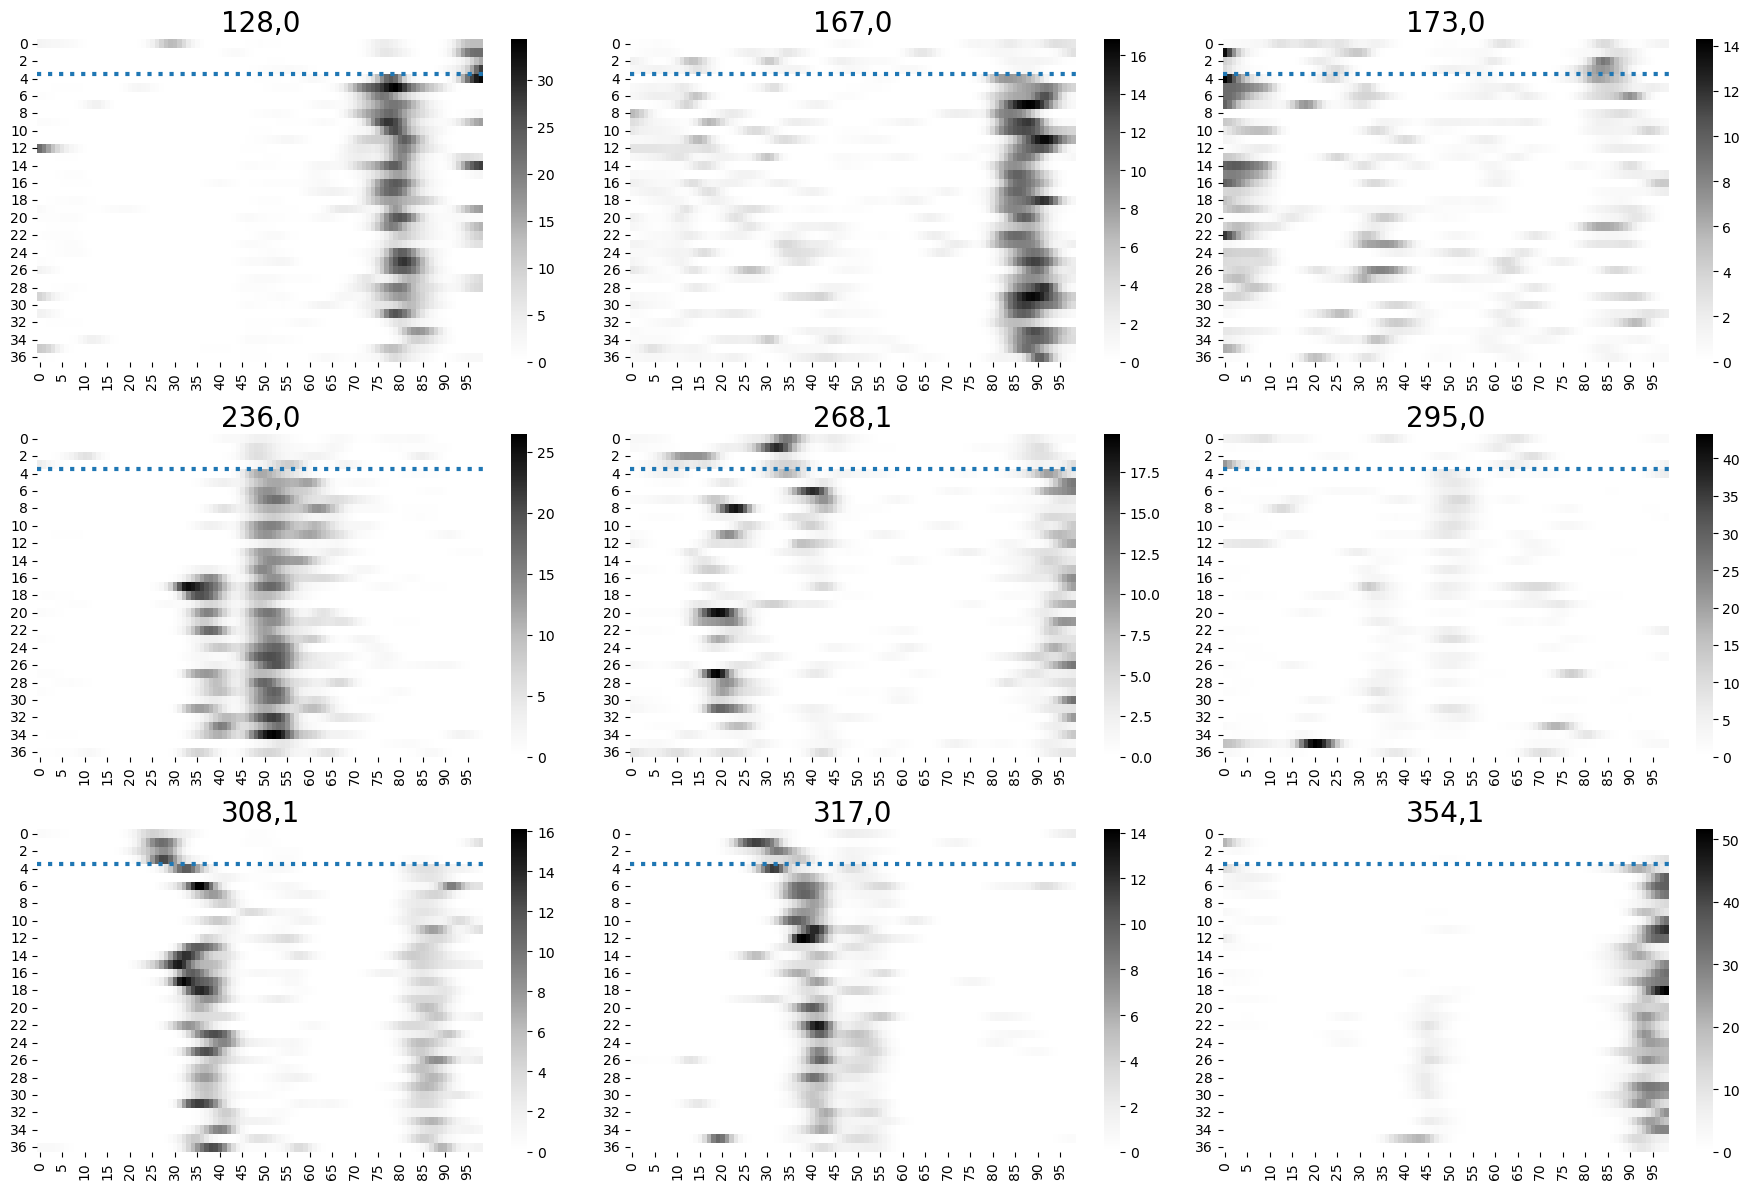

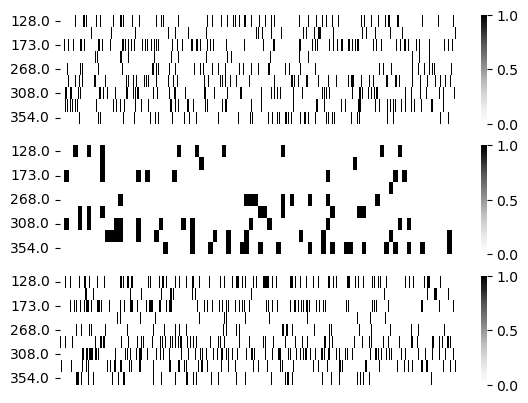

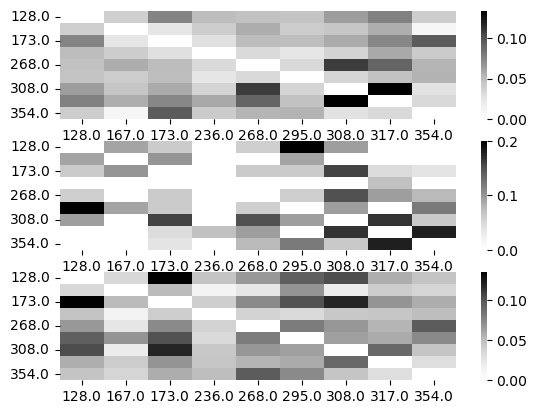

In [119]:
ripple_key = 'participation_in_interval'
ripple_firing_mat_all_ep = res_all_epochs_d['ripple_only'][ripple_key]

trial_index=tr=7
fields_coswitch_in_one_trial = changes_df_one.index[changes_df_one[tr]==1]
nfields = len(fields_coswitch_in_one_trial)

trialtype_for_heatmap=trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)].index[0]
index_within = trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)].values[0]

fig,axs=ph.subplots_wrapper(nfields)
trial_to_mark = index_within
# if trialtype_for_heatmap==which_trialtype:
#     trial_to_mark = index_within
# else:
#     trial_to_mark = None

for ii,(tt,uid,field_id) in enumerate(fields_coswitch_in_one_trial):
    ax=axs.ravel()[ii]
    fr_map = fr_map_trial_df.loc[(trialtype_for_heatmap,uid),:].dropna(axis=1,how='all').T
    ph.ratemap_one_raw(fr_map,trial=trial_to_mark,ax=ax)
    ax.set_title(f'{uid},{field_id}')
    
plt.tight_layout()

nep = ripple_firing_mat_all_ep.columns.get_level_values(0).nunique()
fig,axs=plt.subplots(nep)
uid_coswitch_one_trial_l = fields_coswitch_in_one_trial.get_level_values(1)
for n in range(nep):
    ax = axs.ravel()[n]
    sns.heatmap(data=ripple_firing_mat_all_ep[n].loc[uid_coswitch_one_trial_l],cmap='Greys',ax=ax,xticklabels=False)
    ax.set(xlabel="")

fig,axs=plt.subplots(nep)
for n in range(nep):
    ax = axs.ravel()[n]
    rip_sim_one = ripple_sim_d.loc['ripple_only','participation_in_interval'].loc[n]
    rip_sim_one_sub = rip_sim_one.loc[uid_coswitch_one_trial_l,uid_coswitch_one_trial_l]
    sns.heatmap(rip_sim_one_sub,ax=ax,cmap='Greys')
    
    


In [117]:
ripple_sim_d.loc['ripple_only','participation_in_interval']

/tmp/ipykernel_878037/3831454040.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  ripple_sim_d.loc['ripple_only','participation_in_interval']


1.0       2.0       3.0       4.0       5.0       6.0    \
epoch uid                                                                 
0     1.0    0.000000  0.025974  0.000000  0.029298  0.028892  0.034268   
      2.0    0.025974  0.000000  0.023810  0.013827  0.013376  0.005198   
      3.0    0.000000  0.023810  0.000000  0.009397  0.009091  0.006289   
      4.0    0.029298  0.013827  0.009397  0.000000  0.955851  0.496192   
      5.0    0.028892  0.013376  0.009091  0.955851  0.000000  0.503209   
...               ...       ...       ...       ...       ...       ...   
2     478.0  0.085106  0.017699  0.005376  0.055283  0.055200  0.052239   
      479.0  0.031553  0.008671  0.009901  0.103561  0.102359  0.105960   
      480.0  0.042032  0.011696  0.043860  0.168365  0.170332  0.190168   
      481.0  0.065185  0.037319  0.015396  0.505276  0.506795  0.393043   
      482.0  0.020243  0.011494  0.023077  0.034440  0.033600  0.034554   

                7.0       8.0       9.0       10.0   ...     473.0     474.0  \
epoch uid                                            ...                       
0     1.0    0.028800  0.028962  0.021864  0.029099  ...  0.053333  0.022556   
      2.0    0.013333  0.013669  0.007034  0.013438  ...  0.041667  0.009434   
      3.0    0.009600  0.009841  0.001175  0.010084  ...  0.048780  0.000000   
      4.0    0.958001  0.933546  0.442927  0.915245  ...  0.013827  0.045354   
      5.0    0.990431  0.965976  0.444682  0.943617  ...  0.012834  0.043874   
...               ...       ...       ...       ...  ...       ...       ...   
2     478.0  0.055178  0.055938  0.054154  0.055921  ...  0.033520  0.019685   
      479.0  0.102759  0.102834  0.098431  0.099877  ...  0.000000  0.035616   
      480.0  0.170732  0.170239  0.156187  0.166599  ...  0.012821  0.093812   
      481.0  0.506592  0.505641  0.366702  0.501623  ...  0.020930  0.052990   
      482.0  0.033587  0.034049  0.036391  0.033717  ...  0.000000  0.025000   

                475.0     476.0     477.0     478.0     479.0     480.0  \
epoch uid                                                                 
0     1.0    0.027778  0.080808  0.000000  0.024793  0.023669  0.025907   
      2.0    0.046512  0.040000  0.000000  0.043956  0.006993  0.005479   
      3.0    0.027027  0.028986  0.000000  0.011494  0.014815  0.008403   
      4.0    0.011062  0.029314  0.004422  0.038717  0.062293  0.181319   
      5.0    0.010701  0.028357  0.004815  0.036898  0.063670  0.181721   
...               ...       ...       ...       ...       ...       ...   
2     478.0  0.005405  0.113139  0.000000  0.000000  0.031332  0.021700   
      479.0  0.000000  0.016787  0.000000  0.031332  0.000000  0.092652   
      480.0  0.025918  0.043937  0.020737  0.021700  0.092652  0.000000   
      481.0  0.013067  0.060517  0.006260  0.053104  0.106522  0.154422   
      482.0  0.015385  0.012097  0.010101  0.018349  0.042813  0.019960   

                481.0     482.0  
epoch uid                        
0     1.0    0.028249  0.033333  
      2.0    0.017321  0.021505  
      3.0    0.008074  0.011494  
      4.0    0.449402  0.038143  
      5.0    0.452559  0.036898  
...               ...       ...  
2     478.0  0.053104  0.018349  
      479.0  0.106522  0.042813  
      480.0  0.154422  0.019960  
      481.0  0.000000  0.038344  
      482.0  0.038344  0.000000  

[1446 rows x 482 columns]

In [92]:
fields_coswitch_in_one_trial

MultiIndex([(0.0, 126, 0),
            (0.0, 213, 1),
            (0.0, 220, 0),
            (0.0, 232, 0),
            (0.0, 258, 1),
            (0.0, 278, 0),
            (0.0, 456, 0)],
           )

<Axes: >

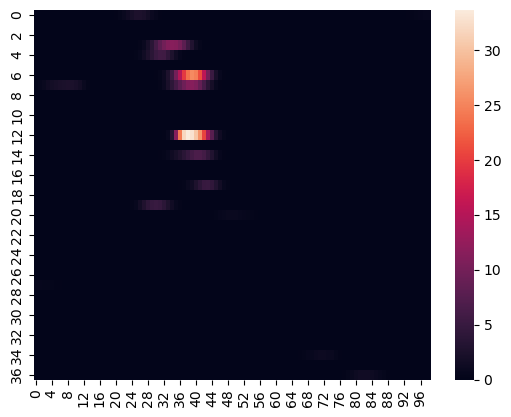

In [102]:
sns.heatmap(data=fr_map_trial_df_all.loc[ani,sess,0,1,456].dropna(axis=1).T)

<Axes: >

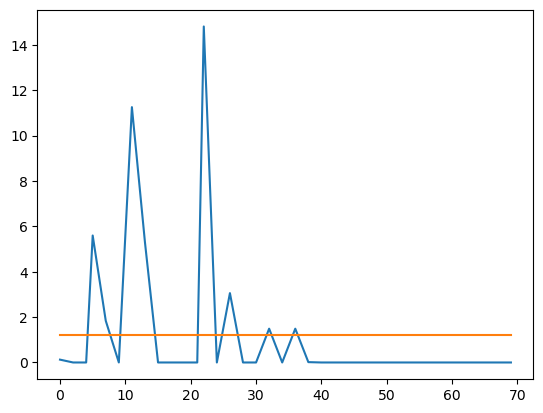

In [104]:
X_raw_all.loc[ani,sess,task_index,1,456,0].dropna().plot()
X_pwc_all.loc[ani,sess,task_index,1,456,0].dropna().plot()

In [68]:
fields_coswitch_in_one_trial

MultiIndex([(   1.0,  29, 0),
            (   1.0,  52, 2),
            (   1.0, 150, 1),
            (   1.0, 265, 0),
            (   1.0, 381, 0),
            ('both',  93, 0)],
           )

In [46]:
sw_sim_one

,3.0,29.0,30.0,35.0,36.0,37.0,38.0,39.0,40.0,43.0,...,430.0,436.0,443.0,448.0,452.0,454.0,455.0,456.0,459.0,479.0
3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
456.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
459.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# high and low ripple cofiring, frmap

In [ ]:
ep = 2
ripple_sim_one = ripple_sim_d.loc['ripple_only',ripple_key,ep].loc[cell_cols_d['pyr'],cell_cols_d['pyr']]

n_high_ripple_sim = 10
high_rip_sim_l = ripple_sim_one.loc[uid].sort_values(ascending=False).iloc[:n_high_ripple_sim]
low_rip_sim_l = ripple_sim_one.loc[uid].sort_values(ascending=True).iloc[:n_high_ripple_sim]

In [ ]:
ii=4
row=all_sw_d_one.query('switch==1').iloc[ii]
uid,field_id,trialtype = row['uid'],row['field_index'],row['trialtype']
index_within =row['index_within']
trial_index = row['trial_index']
which_trialtype=trial_index_to_index_within_df_one.loc[task_index].loc[(slice(None),trial_index)].index[0]

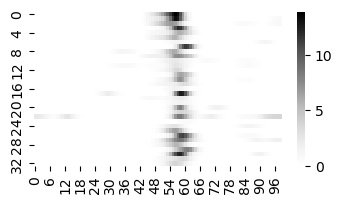

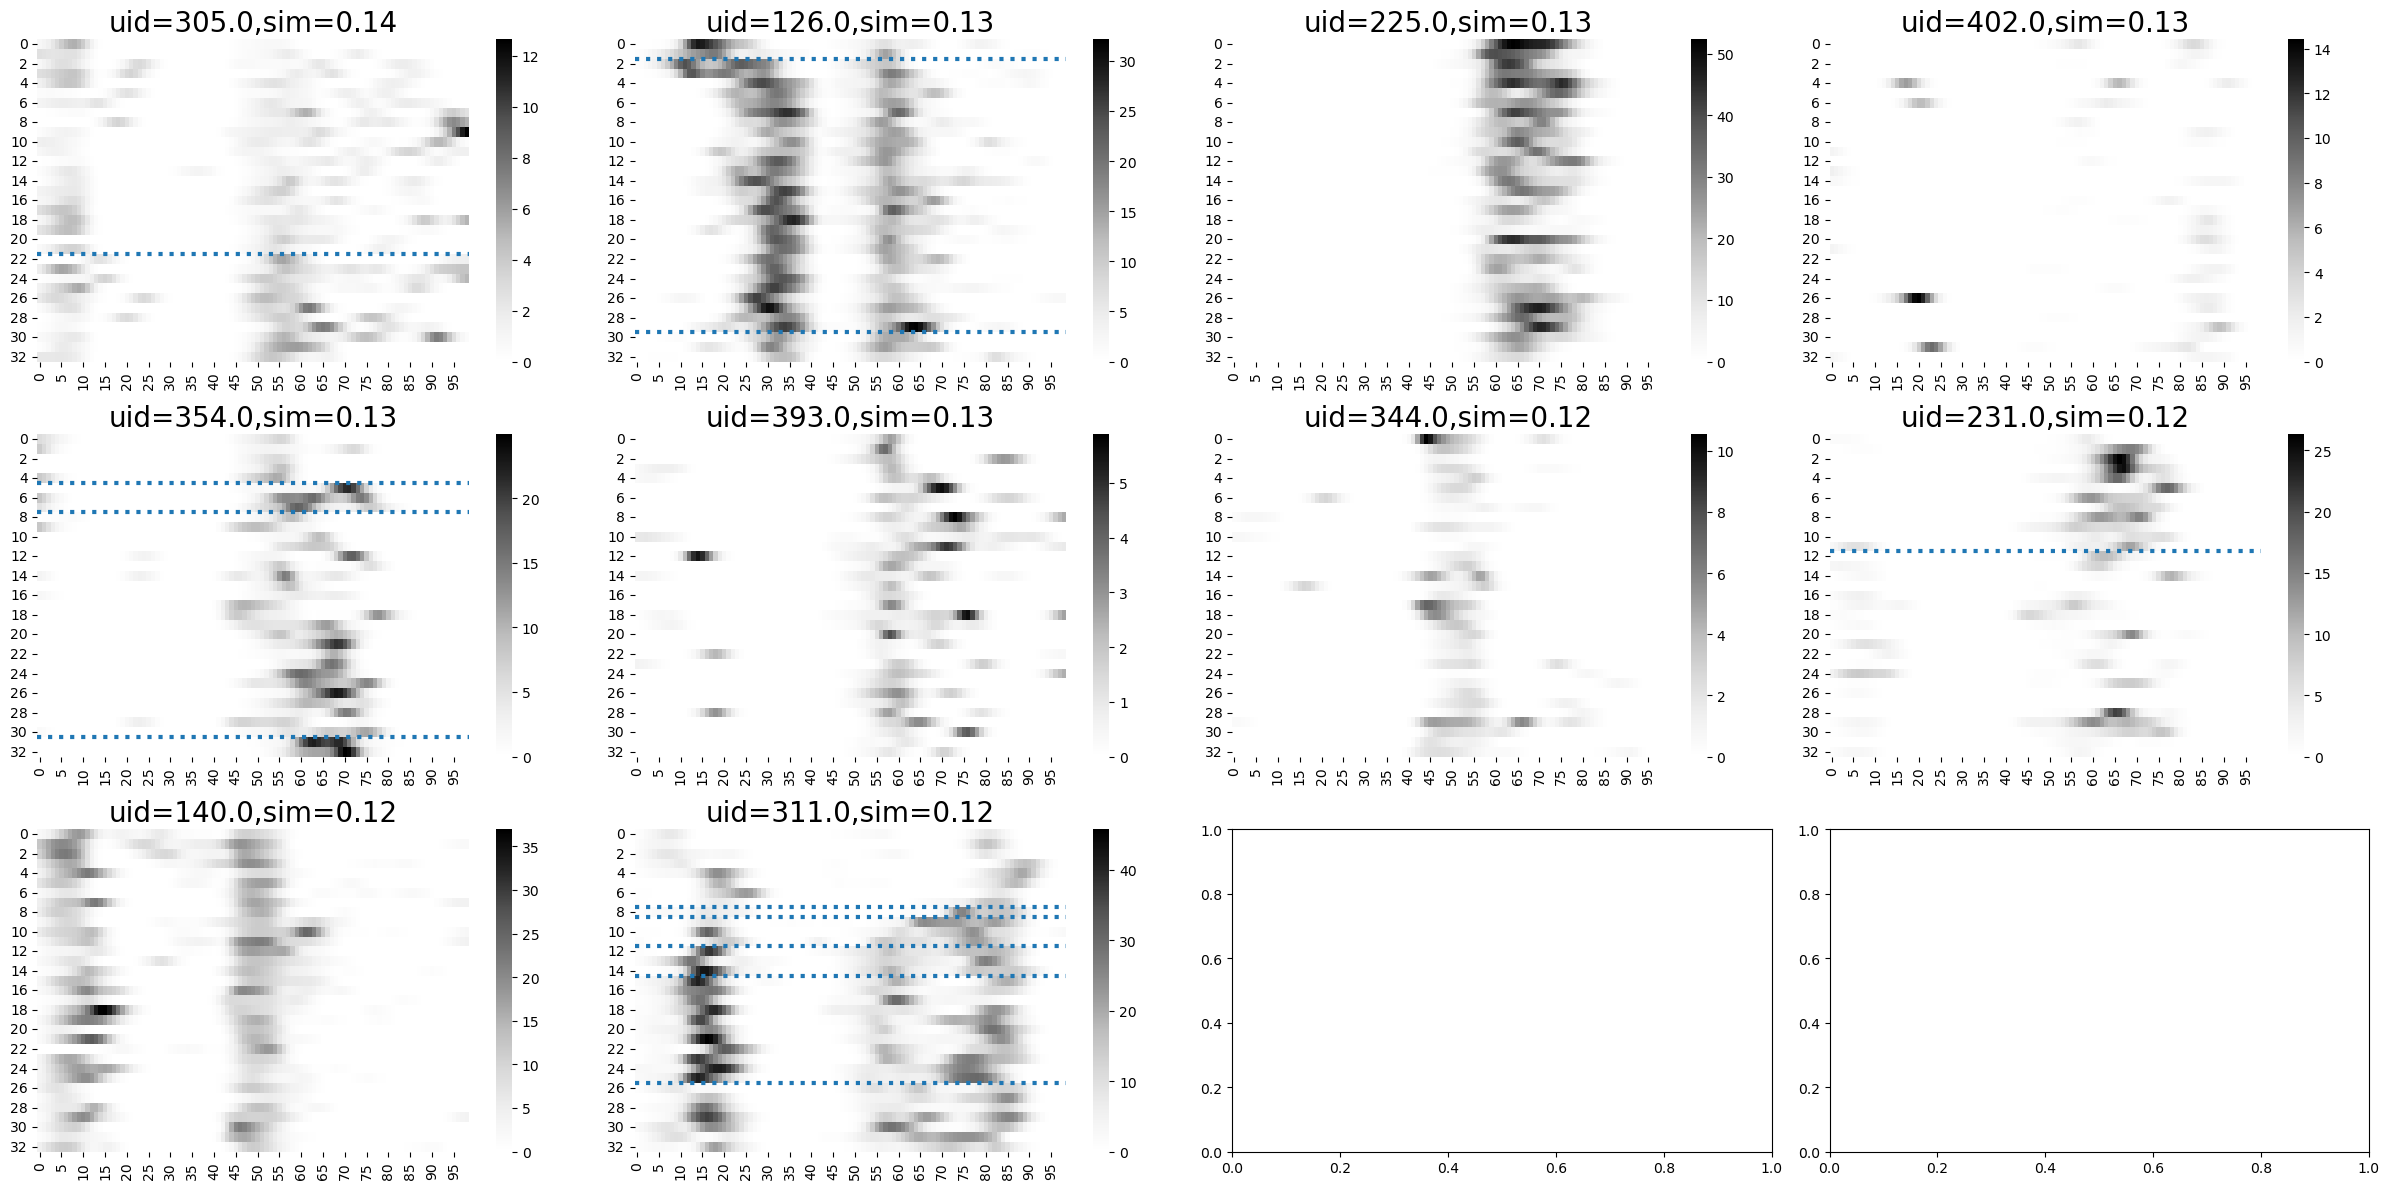

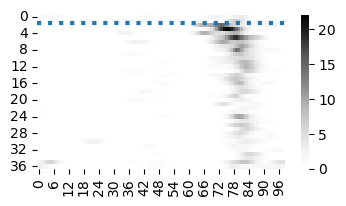

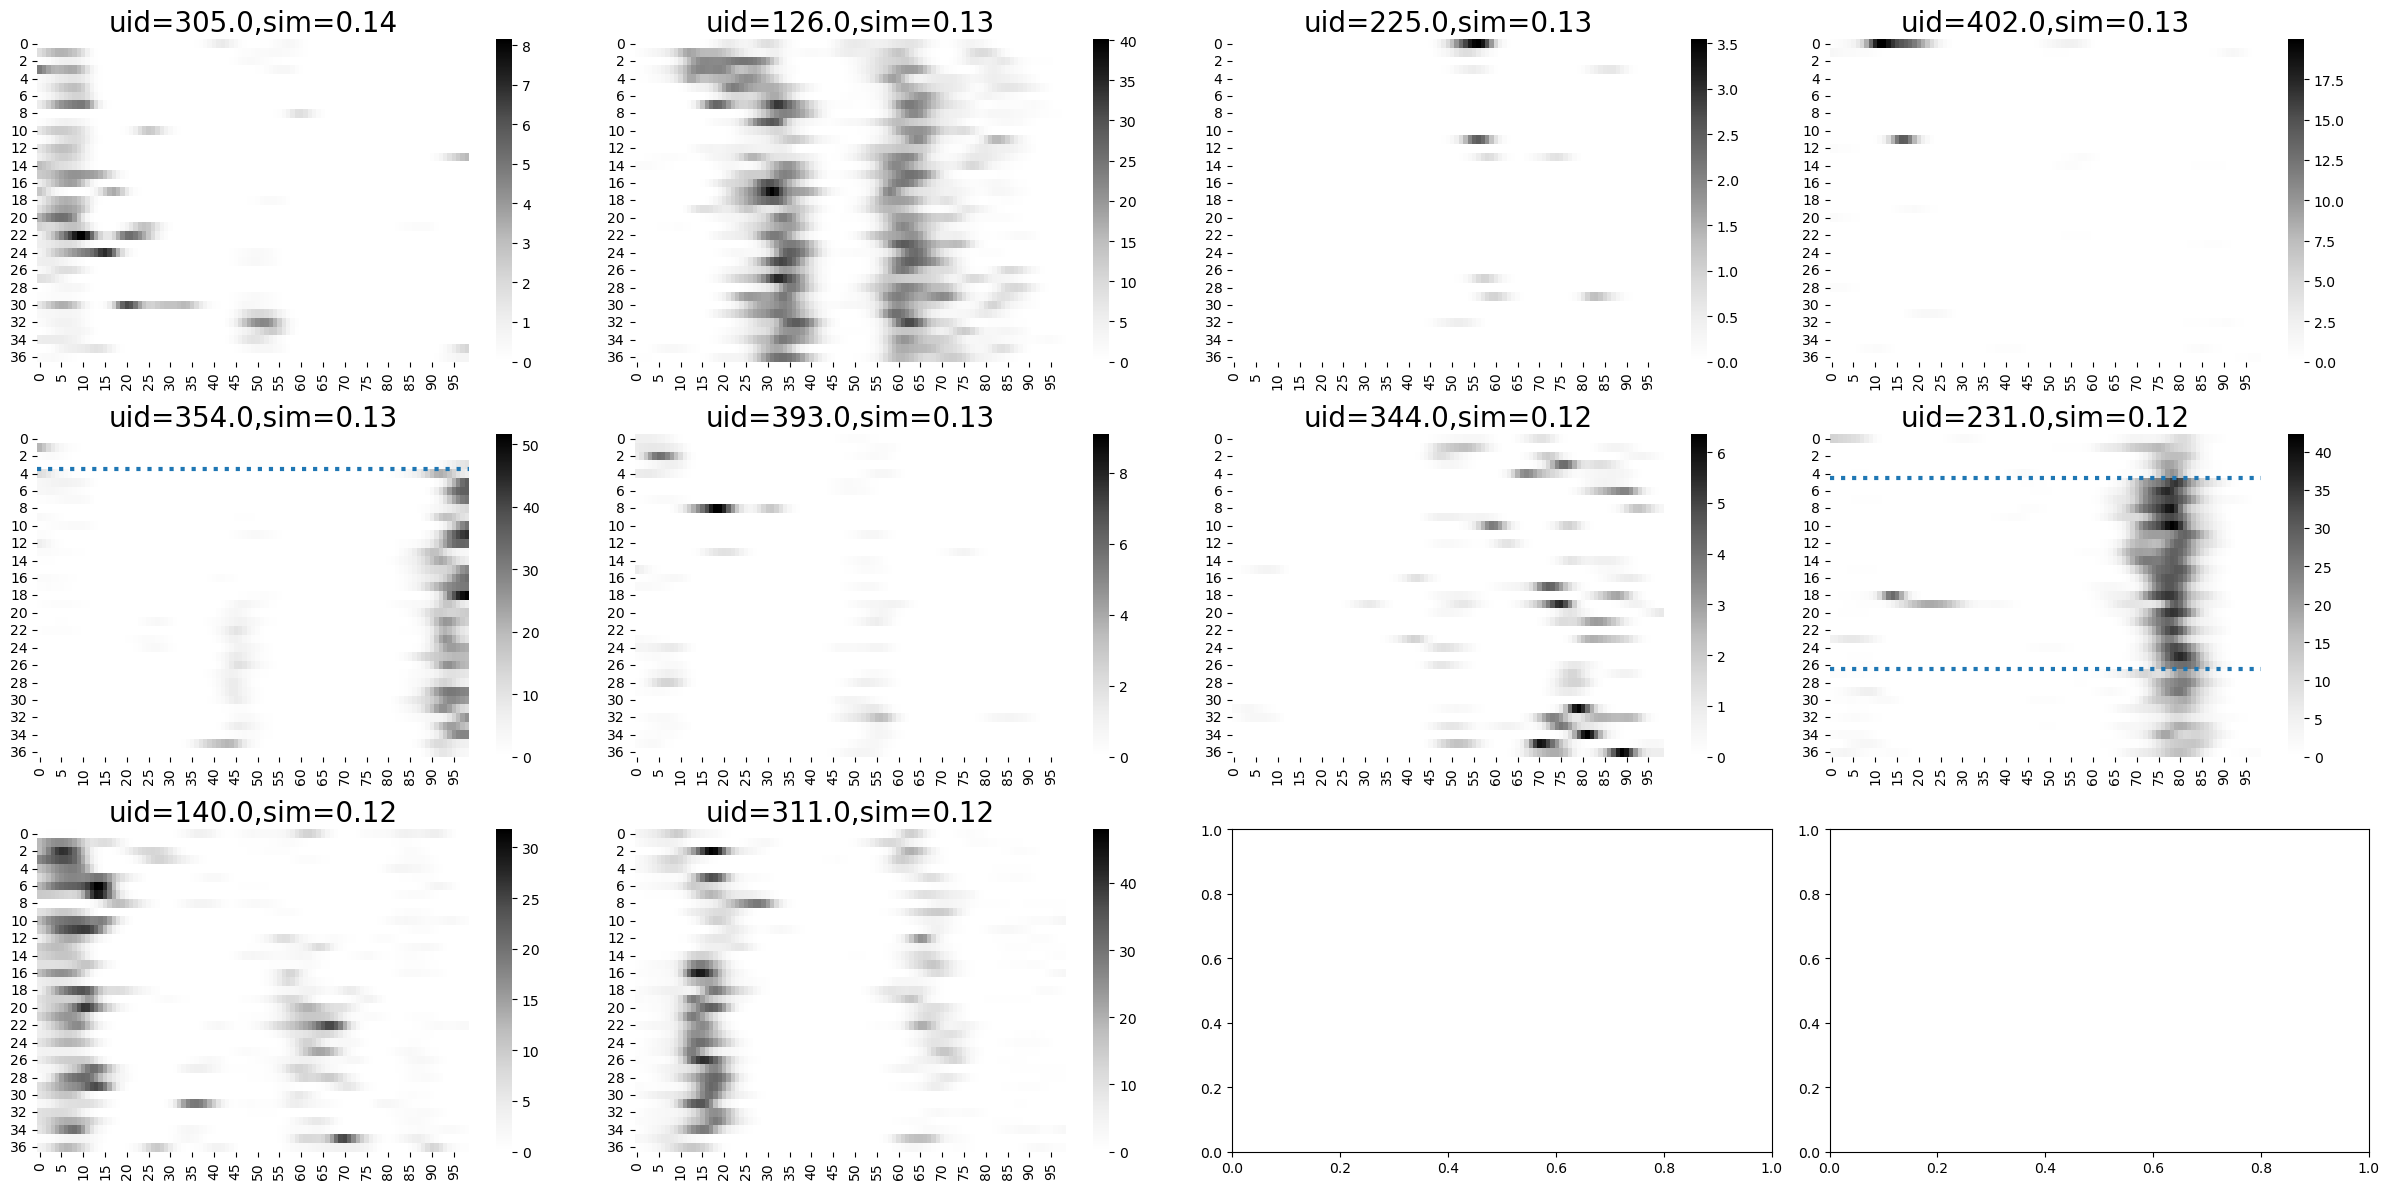

In [33]:
for trialtype_for_heatmap in [0,1]:
#     fig,axs=plt.subplots(2,n_high_ripple_sim,figsize=(n_high_ripple_sim*6,2*4))
#     ax=axs[0,0]
    fig,ax=plt.subplots(figsize=(4,2))
#     trialtype_for_heatmap = 0 if trialtype=='both' else trialtype
    fr_map = fr_map_trial_df.loc[(trialtype_for_heatmap,uid),:].dropna(axis=1,how='all').T
#     sns.heatmap(data=fr_map,ax=ax)
    
    trial_to_mark = prep_switch_trial_for_trialtype_seperated_heatmap(row,trial_index_to_index_within_df_one,trialtype_for_heatmap,task_index=task_index)

    ph.ratemap_one_raw(fr_map,trial=trial_to_mark,ax=ax)
    fig,axs=ph.subplots_wrapper(n_high_ripple_sim)
    for n in range(n_high_ripple_sim):
#         ax=axs[1,n]
        ax=axs.ravel()[n]
        uid_high_sim = high_rip_sim_l.index[n]
        if uid_high_sim in all_sw_d_one['uid']:
            all_sw_d_one_sub=all_sw_d_one.loc[all_sw_d_one['uid']==uid_high_sim]
            trial_l = []
            for _,rr in all_sw_d_one_sub.iterrows():
                trial = prep_switch_trial_for_trialtype_seperated_heatmap(rr,trial_index_to_index_within_df_one,trialtype_for_heatmap,task_index=task_index)
                trial_l.append(trial)
        else:
            trial_l=None
        sim = high_rip_sim_l.iloc[n]
        try:
            fr_map = fr_map_trial_df.loc[(trialtype_for_heatmap,uid_high_sim),:].dropna(axis=1,how='all').T
#             sns.heatmap(data=fr_map,ax=ax)
            ph.ratemap_one_raw(fr_map,trial=trial_l,ax=ax)
            ax.set_title(f'uid={uid_high_sim},sim={sim:.02f}')
        except:
            pass
    plt.tight_layout()

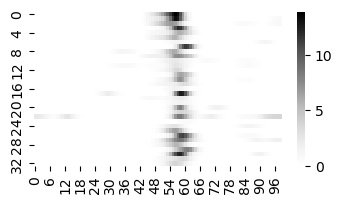

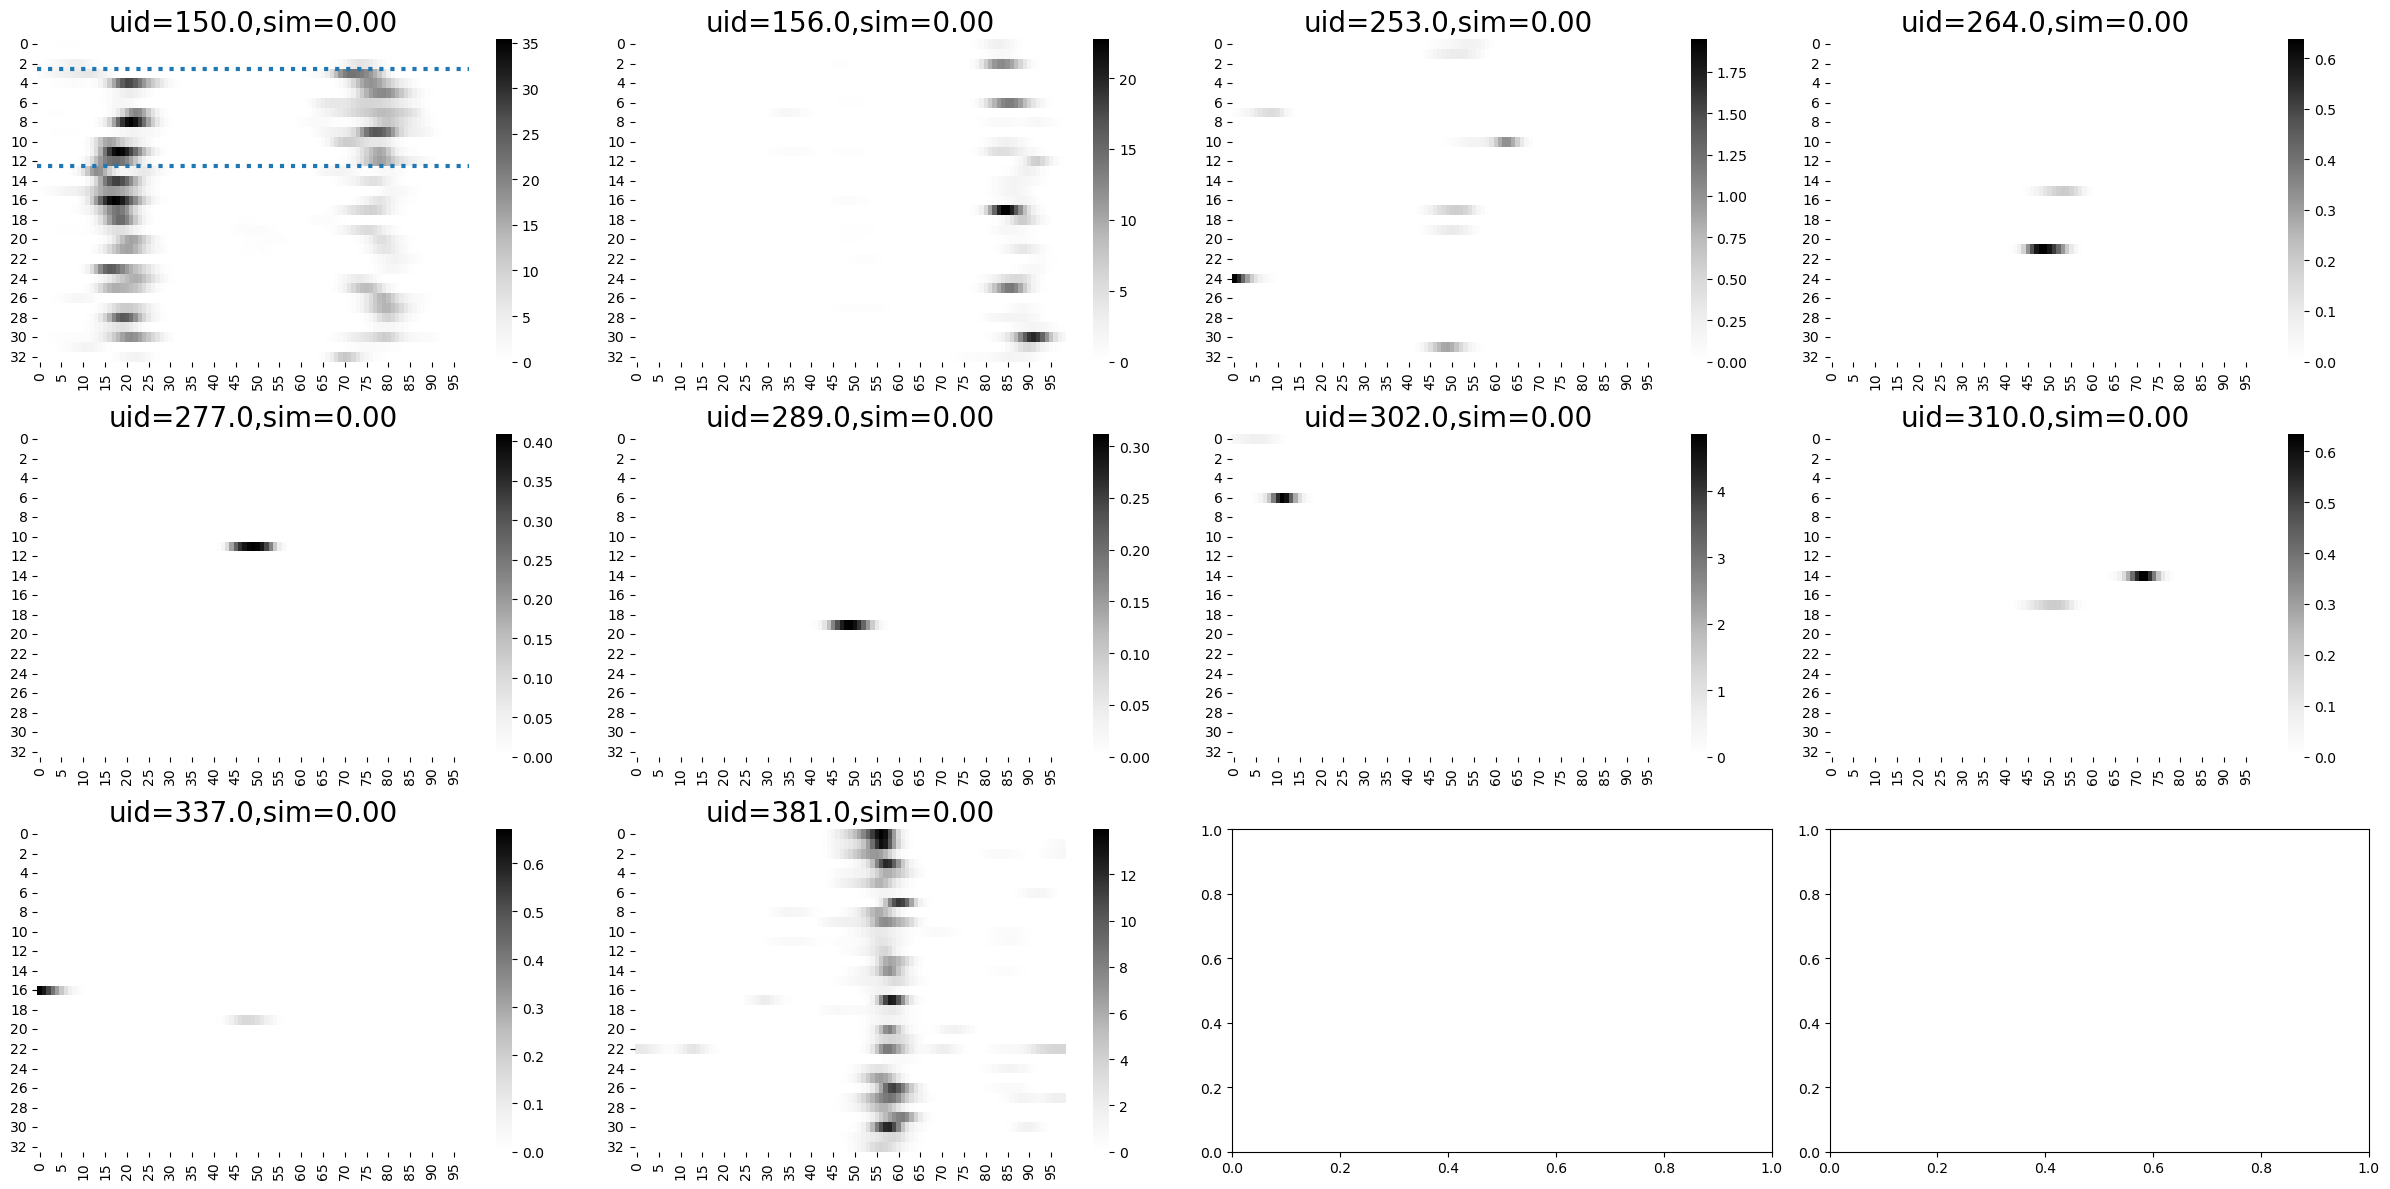

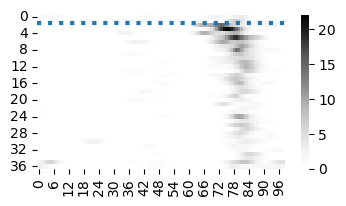

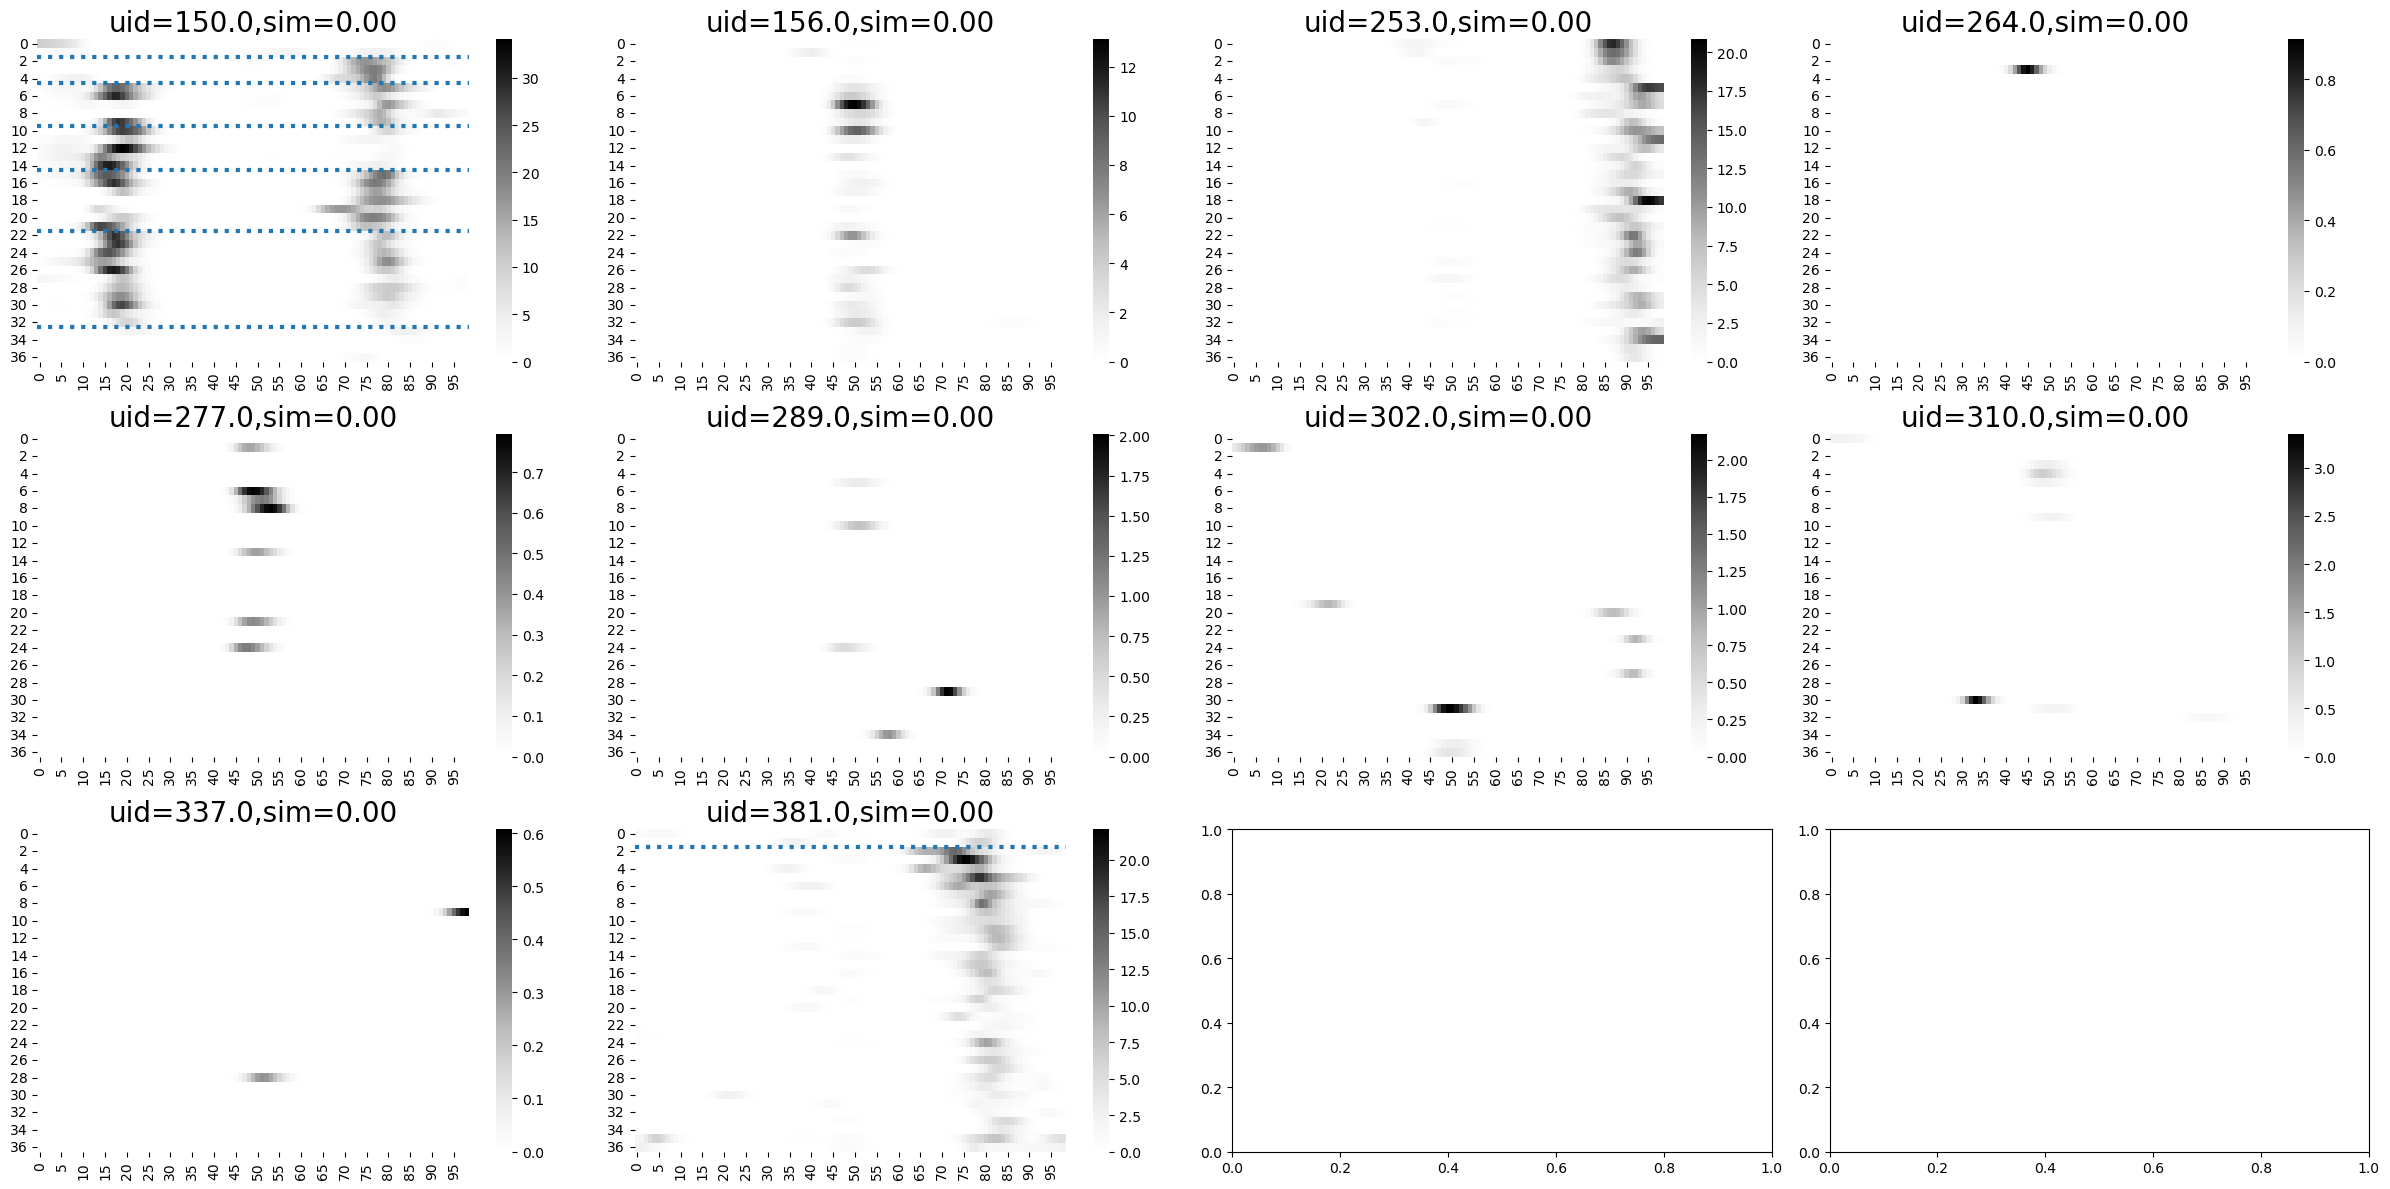

In [34]:
for trialtype_for_heatmap in [0,1]:
#     fig,axs=plt.subplots(2,n_high_ripple_sim,figsize=(n_high_ripple_sim*6,2*4))
#     ax=axs[0,0]
    fig,ax=plt.subplots(figsize=(4,2))
#     trialtype_for_heatmap = 0 if trialtype=='both' else trialtype
    fr_map = fr_map_trial_df.loc[(trialtype_for_heatmap,uid),:].dropna(axis=1,how='all').T
#     sns.heatmap(data=fr_map,ax=ax)
    
    trial_to_mark = prep_switch_trial_for_trialtype_seperated_heatmap(row,trial_index_to_index_within_df_one,trialtype_for_heatmap,task_index=task_index)

    ph.ratemap_one_raw(fr_map,trial=trial_to_mark,ax=ax)
    fig,axs=ph.subplots_wrapper(n_high_ripple_sim)
    for n in range(n_high_ripple_sim):
#         ax=axs[1,n]
        ax=axs.ravel()[n]
        uid_high_sim = low_rip_sim_l.index[n]
        if uid_high_sim in all_sw_d_one['uid']:
            all_sw_d_one_sub=all_sw_d_one.loc[all_sw_d_one['uid']==uid_high_sim]
            trial_l = []
            for _,rr in all_sw_d_one_sub.iterrows():
                trial = prep_switch_trial_for_trialtype_seperated_heatmap(rr,trial_index_to_index_within_df_one,trialtype_for_heatmap,task_index=task_index)
                trial_l.append(trial)
        else:
            trial_l=None
        sim = low_rip_sim_l.iloc[n]
        try:
            fr_map = fr_map_trial_df.loc[(trialtype_for_heatmap,uid_high_sim),:].dropna(axis=1,how='all').T
#             sns.heatmap(data=fr_map,ax=ax)
            ph.ratemap_one_raw(fr_map,trial=trial_l,ax=ax)
            ax.set_title(f'uid={uid_high_sim},sim={sim:.02f}')
        except:
            pass
    plt.tight_layout()